# Predicting Lending Decisions: Analysis of the LendingClub Dataset I - II parts

## Introduction

The file provides analysis of the dataset of the LendingClub company (https://www.lendingclub.com/) which offers online personal and business loans (the dataset is available in the Kaggle repository here: https://www.kaggle.com/datasets/wordsforthewise/lending-club). The dataset includes two files: 1) a file with data on customers whose requests for loans were accepted (2260701 customers, 150 variables); 2) a file with data on rejected requests (27648741 requests, 9 variables). The dataset includes loan data of the company in the period from 2007 to 2018.

Explanations of variable names are provided in the data dictionary also available in the Kaggle (https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv?select=LCDataDictionary.xlsx). 

Purposes of the analysis are:
- to create a machine learning model to classify loans into accepted/rejected;
- to predict the grade for the loan; 
- to predict the subgrade;
- to predict the interest rate.

Additional learning objectives are these:
- practice downloading datasets from external sources;
- practice performing EDA;
- practice applying statistical inference procedures;
- practice using various types of machine learning models;
- practice building ensembles of machine learning models;
- practice using hyperparameter tuning;
- practice using AutoML tools;
- practice deploying machine learning models;
- practice visualizing data with Matplotlib & Seaborn;
- practice reading data, performing queries, and filtering data.

The analysis consists of several parts: the initial exploratory data analysis (in this part  the datasets are imported, examined and prepared for the further analysis) and three major parts which include the analysis and modelling in order to achieve research purposes set above. Each of these three parts itself includes the exloratory data analysis, statistical inferences, and building, tuning, evaluating and deploying machine learning models related to the particular research purpose.

### Importing libraries

The main libraries which will be used for the manipulation with data are pandas and numpy. Matplotlib, seaborn and yellowbrick will be used for data visualization. Scipy, Statsmodels, Researchpy, Math, Random will be used for conducting statistical tests, calculating confidence intervals. Sklearn will be used for spliting data into training and testing samples, building and testing machine learning models.

In [2]:
import numpy as np 
import pandas as pd
import sqlite3
import duckdb
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from scipy import stats
from scipy.stats import chi2_contingency, norm 
import researchpy as rp

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import optuna

import sklearn
import sklearn.ensemble
import sklearn.model_selection
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
import xgboost as xg

from imblearn.pipeline import make_pipeline, Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from yellowbrick.classifier import confusion_matrix, ClassificationReport

import joblib
import shap

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from lending_utils import *


## I. INITIAL EXPLORATORY DATA ANALYSIS

#### Importing the data

The LendingClub datasets 'accepted.csv' and 'rejected.csv' are imported and saved into pandas dataframe.

In [3]:
accepted = pd.read_csv("data/accepted.csv")


In [4]:
rejected = pd.read_csv("data/rejected.csv")

#### Examining the data

It can be observed that the 'accepted' dataframe contains 150 columns (various features of customers, dates when funding decision were made, etc.) and 2260701 rows (data on customers whose requests for loans were accepted). The dataframe 'rejected' contains 9 columns (features of requests, application dates) and 27648741 rows (requests for loans which were rejected).


In [5]:
accepted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [6]:
pd.set_option('display.max_columns', 500)
accepted.tail(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
2260696,88985880,NaN,40000.0,40000.0,40000.0,60 months,10.49,859.56,B,B3,Vice President,9 years,MORTGAGE,227000.0,Verified,Oct-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,NaN,907xx,CA,12.75,7.0,Feb-1995,705.0,709.0,1.0,9.0,NaN,5.0,0.0,8633.0,64.9,37.0,f,23252.59,23252.59,24903.93,24903.93,16747.41,8156.52,0.00,0.0,0.0,Mar-2019,859.56,Apr-2019,Mar-2019,724.0,720.0,0.0,10.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,28398.0,0.0,2.0,0.0,1.0,15.0,19765.0,46.0,0.0,0.0,5141.0,51.0,13300.0,3.0,0.0,2.0,2.0,5680.0,4070.0,66.9,0.0,0.0,154.0,258.0,33.0,15.0,3.0,41.0,9.0,1.0,9.0,6.0,2.0,3.0,2.0,15.0,9.0,3.0,23.0,3.0,5.0,0.0,0.0,7.0,0.0,75.7,50.0,0.0,0.0,55970.0,28398.0,12300.0,42670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260697,88224441,NaN,24000.0,24000.0,24000.0,60 months,14.49,564.56,C,C4,Program Manager,6 years,RENT,110000.0,Not Verified,Oct-2016,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,334xx,FL,18.30,0.0,Jul-1999,660.0,664.0,0.0,67.0,72.0,10.0,1.0,17641.0,68.1,31.0,f,0.00,0.00,6755.40,6755.40,3521.91,3233.49,0.00,0.0,0.0,Oct-2017,564.56,NaN,Mar-2019,594.0,590.0,0.0,67.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,62426.0,0.0,2.0,0.0,2.0,20.0,44785.0,78.0,1.0,5.0,6172.0,73.0,25900.0,0.0,0.0,1.0,7.0,6243.0,4660.0,77.5,0.0,0.0,132.0,206.0,9.0,9.0,2.0,9.0,NaN,9.0,NaN,1.0,5.0,7.0,5.0,15.0,4.0,8.0,24.0,7.0,10.0,0.0,0.0,0.0,1.0,96.2,40.0,1.0,0.0,84664.0,62426.0,20700.0,58

In the 'accepted' dataframe there are rows both individuals and for companies.

In [7]:
accepted["application_type"].value_counts()

Individual    2139958
Joint App      120710
Name: application_type, dtype: int64

In there 'rejected' dataframe there are not rows for companies.

In [8]:
rejected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648741 entries, 0 to 27648740
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  object 
 5   Zip Code              object 
 6   State                 object 
 7   Employment Length     object 
 8   Policy Code           float64
dtypes: float64(3), object(6)
memory usage: 1.9+ GB


In [9]:
rejected.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


#### Preparing the data

It can be seen that the dataframe "accepted", beginning from the row index 2260699, includes rows with missing data. These rows are removed from the dataframe.

Also, geographical and personal data would certainly not be used for the analysis, thus, these columns were removed from the dataframes.

In [10]:
accepted_mod = accepted.loc[:2260698, :]
accepted_mod = accepted_mod.drop(columns=['member_id', 'url', 'zip_code', 'addr_state'])

In [11]:

rejected_mod = rejected.drop(columns=["Zip Code", "State"])

In order to prepare the data for the further analysis, colums with dates were transformed into the datatime format.

In [12]:
accepted_mod["issue_d"] = pd.to_datetime(accepted_mod["issue_d"])

In [13]:
rejected_mod["Application Date"] = pd.to_datetime(rejected_mod["Application Date"])

Also, columns of the dataframe 'rejected' were renamed, in order to make them readable by the duckdb.

In [14]:
rejected_mod.columns = ['amount_requested','application_date','loan_title',
                    'risk_score','dti','emp_length','policy_code']
rejected_mod.head()

,amount_requested,application_date,loan_title,risk_score,dti,emp_length,policy_code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,< 1 year,0.0


In [15]:
rejected_mod.reset_index(inplace=True)
rejected_mod.rename(columns={'index': 'id'}, inplace=True)


#### Counting numbers of applications by years

It was checked if data in the 'accepted' and 'rejected dataframes were from the same time frame and it was found that they were from the same timeframe.

In [16]:
accepted_by_date = duckdb.sql("""SELECT
                      CAST(EXTRACT(year FROM issue_d) AS INTEGER) as application_year,
                      COUNT(id) AS number_of_accepted_applications
                      FROM accepted_mod
                      GROUP BY application_year
                      ORDER BY application_year
                            """).df()
accepted_by_date.set_index("application_year")

,number_of_accepted_applications
application_year,
NaN,31
2007.0,603
2008.0,2393
2009.0,5281
2010.0,12537
2011.0,21721
2012.0,53367
2013.0,134814
2014.0,235629


In [17]:
rejected_by_date = duckdb.sql("""SELECT
                      CAST(EXTRACT(year FROM application_date) AS INTEGER) as application_year,
                      COUNT(id) AS number_of_rejected_applications
                      FROM rejected_mod
                      GROUP BY application_year
                      ORDER BY application_year
                            """).df()
rejected_by_date.set_index("application_year")

,number_of_rejected_applications
application_year,
2007,5274
2008,25596
2009,56991
2010,112561
2011,217792
2012,337277
2013,760942
2014,1933700
2015,2859379


## II. PREDICTING ACCEPTED AND REJECTED LOANS

In order to achieve the first research purpose "to build a machine learning model which could be used for predicting accepted and rejected loans", feature variables and a target variable had to be selected and transformed. 

The target variable was created by merging the 'accepted_mod' and 'rejected_mod' dataframes on the row axis and creating a new binary variable 'loan_status' with a values 0 (all rows from the dataframe "rejected_mod'  were appended with values 0 of the variable "loan_status" after dataframes were merged) and 1 (all rows from the dataframe "accepted_mod' were appended with values 1 of the variable "loan_status"). 

As there were less columns in the dataframe "rejected_mod", feature variables were selected by finding which variables in the 'accepted_mod' dataframe were comparable with variables in the 'rejected_mod' dataframe. After examining the data dictionary, it was found that:
- 'dti' variable ("a ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income is present") is present in both dataframes and could be used as a feature variable;
- 'risk_score' variable is defined as 'For applications prior to November 5, 2013 the risk score is the borrower's FICO score. For applications after November 5, 2013 the risk score is the borrower's Vantage score'; thus the means of variables "fico_range_low" and "fico_range_high" (defined as "the lower and upper boundary ranges the borrower’s FICO at loan origination belongs to") from the "accepted_mod" could be comparable with the "risk_score" variable from the 'rejected_mod' dataframe;
- the 'emp_length' variable (defined as 'Employment length in years') also could be used as a feature variable as it is present in both dataframes;
- it was supposed that the 'policy_code' variable (defined as 'publicly available policy_code=1 new products not publicly available policy_code=2'; more on the meaning of this variable: https://news.fintechnexus.com/policy-code-2-loans-lending-club/) also could be used as a feature variable as it is present in both dataframes; however, after the exploration of the variable it was decided not to include it into set of features to be used for machine learning.

### Examining and transforming individual variables

It was decided to examine those variables which were found in both dataframe (in order to later use them as features when both dataframes would be merged).

#### Categorical variables:

The only categorical variable found in both dataframes is 'policy_mode'. However, after its examination it appeared that its values in both dataframes differ and their meanings are unclear. It was decided to remove this variable from the list of features.

In [18]:
accepted_mod["policy_code"].value_counts()

1.0    2260668
Name: policy_code, dtype: int64

In [19]:
rejected_mod["policy_code"].value_counts()

0.0    27559694
2.0       88129
Name: policy_code, dtype: int64

#### Numerical variables:

Values of numerical features were adjusted that they could be comparable in both dataframes.

In [20]:
rejected_mod['dti'] = rejected_mod['dti'].replace('%', '', regex=True).astype(float)

In [21]:
accepted_mod_mod = duckdb.sql("""SELECT
                      loan_amnt AS loan_amount,
                      CASE
                      WHEN emp_length = '< 1 year' THEN 0
                      WHEN emp_length = '1 year' THEN 1
                      WHEN emp_length = '2 years' THEN 2
                      WHEN emp_length = '3 years' THEN 3
                      WHEN emp_length = '4 years' THEN 4
                      WHEN emp_length = '5 years' THEN 5
                      WHEN emp_length = '6 years' THEN 6
                      WHEN emp_length = '7 years' THEN 7
                      WHEN emp_length = '8 years' THEN 8
                      WHEN emp_length = '9 years' THEN 9
                      ELSE 10 END AS emp_length,
                      dti,
                      (fico_range_low + fico_range_high)/2 AS risk_score
                      FROM accepted_mod
                            """).df()
accepted_mod_mod.head()

,loan_amount,emp_length,dti,risk_score
0,3600.0,10,5.91,677.0
1,24700.0,10,16.06,717.0
2,20000.0,10,10.78,697.0
3,35000.0,10,17.06,787.0
4,10400.0,3,25.37,697.0


In [22]:
rejected_mod_mod = duckdb.sql("""SELECT
                      amount_requested AS loan_amount,
                      CASE
                      WHEN emp_length = '< 1 year' THEN 0
                      WHEN emp_length = '1 year' THEN 1
                      WHEN emp_length = '2 years' THEN 2
                      WHEN emp_length = '3 years' THEN 3
                      WHEN emp_length = '4 years' THEN 4
                      WHEN emp_length = '5 years' THEN 5
                      WHEN emp_length = '6 years' THEN 6
                      WHEN emp_length = '7 years' THEN 7
                      WHEN emp_length = '8 years' THEN 8
                      WHEN emp_length = '9 years' THEN 9
                      ELSE 10 END AS emp_length,
                      dti,
                      risk_score
                      FROM rejected_mod
                            """).df()
rejected_mod_mod.head()

,loan_amount,emp_length,dti,risk_score
0,1000.0,4,10.00,693.0
1,1000.0,0,10.00,703.0
2,11000.0,1,10.00,715.0
3,6000.0,0,38.64,698.0
4,1500.0,0,9.43,509.0


In [23]:
accepted_mod_mod.describe()

,loan_amount,emp_length,dti,risk_score
count,2.260668e+06,2.260699e+06,2.258957e+06,2.260668e+06
mean,1.504693e+04,6.195808e+00,1.882420e+01,7.005883e+02
std,9.190245e+03,3.734493e+00,1.418333e+01,3.301081e+01
min,5.000000e+02,0.000000e+00,-1.000000e+00,6.120000e+02
25%,8.000000e+03,3.000000e+00,1.189000e+01,6.770000e+02
50%,1.290000e+04,7.000000e+00,1.784000e+01,6.920000e+02
75%,2.000000e+04,1.000000e+01,2.449000e+01,7.170000e+02
max,4.000000e+04,1.000000e+01,9.990000e+02,8.475000e+02


In [24]:
rejected_mod_mod.describe()

,loan_amount,emp_length,dti,risk_score
count,2.764874e+07,2.764874e+07,2.764874e+07,9.151111e+06
mean,1.313324e+04,1.032170e+00,1.433401e+02,6.281721e+02
std,1.500964e+04,2.567930e+00,1.053916e+04,8.993679e+01
min,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00
25%,4.800000e+03,0.000000e+00,8.060000e+00,5.910000e+02
50%,1.000000e+04,0.000000e+00,1.998000e+01,6.370000e+02
75%,2.000000e+04,0.000000e+00,3.661000e+01,6.750000e+02
max,1.400000e+06,1.000000e+01,5.000003e+07,9.900000e+02


It was checked which values are out of the scales of the numerical variables. The values out of the scales will be removed later. 

In [25]:
accepted_mod_mod[accepted_mod_mod["dti"] > 100].value_counts("dti")

dti
999.00    135
101.33      5
100.60      5
108.00      4
102.40      4
         ... 
132.05      1
132.00      1
131.94      1
131.88      1
151.06      1
Length: 2154, dtype: int64

In [26]:
rejected_mod_mod[rejected_mod_mod["dti"] > 100].value_counts("dti")

dti
9999.00        76984
99999.00        5652
199998.00       1391
200.00           478
300.00           396
               ...  
1273.58            1
576.77             1
1273.63            1
1273.75            1
50000031.49        1
Length: 116143, dtype: int64

In [27]:
accepted_mod_mod[accepted_mod_mod["risk_score"] > 850].value_counts("risk_score")

Series([], dtype: int64)

In [28]:
rejected_mod_mod[rejected_mod_mod["risk_score"] > 850].value_counts("risk_score")

risk_score
853.0    2229
990.0     751
851.0     700
852.0     692
856.0     568
         ... 
981.0      15
985.0      15
979.0      14
989.0      13
988.0      10
Length: 140, dtype: int64

In [29]:
accepted_mod_mod[accepted_mod_mod["risk_score"] < 300].value_counts("risk_score")

Series([], dtype: int64)

In [30]:
rejected_mod_mod[rejected_mod_mod["risk_score"] < 300].value_counts("risk_score")

risk_score
0.0    86754
dtype: int64

The values out of teh scales are removed (see bellow).

In [31]:
accepted_mod_mod = accepted_mod_mod[accepted_mod_mod.dti <= 100]
accepted_mod_mod = accepted_mod_mod[accepted_mod_mod.risk_score <= 850]
accepted_mod_mod = accepted_mod_mod[accepted_mod_mod.risk_score >= 300]

In [32]:
rejected_mod_mod = rejected_mod_mod[rejected_mod_mod.dti <= 100]
rejected_mod_mod = rejected_mod_mod[rejected_mod_mod.risk_score <= 850]
rejected_mod_mod = rejected_mod_mod[rejected_mod_mod.risk_score >= 300]

Numerical variables in both dataframes are plotted by histogram plots. 

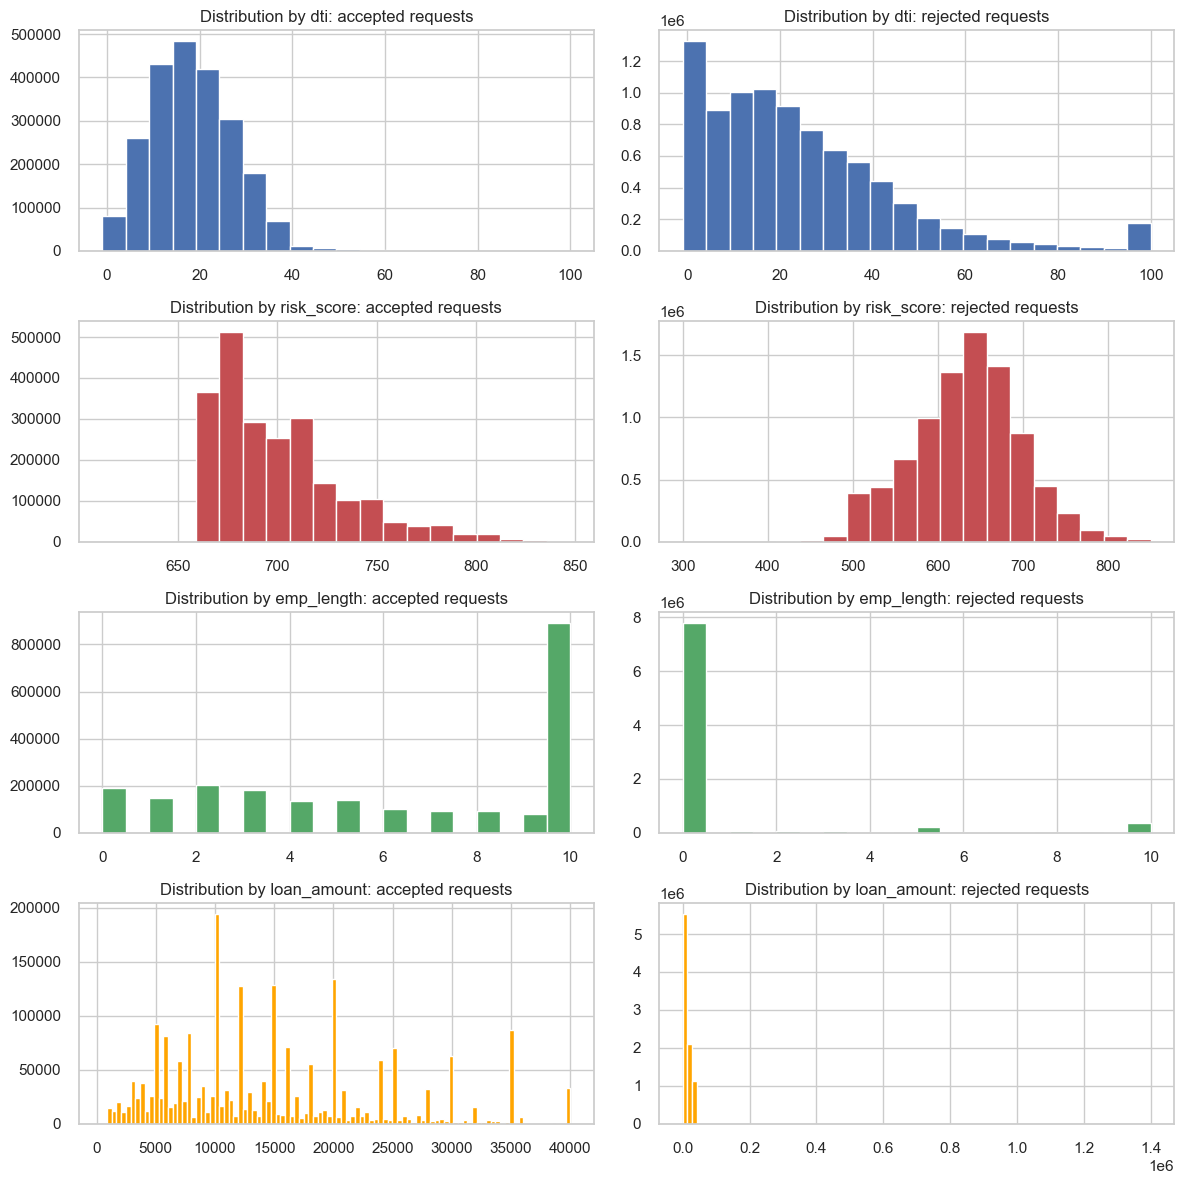

In [33]:
fig, axs = plt.subplots(4, 2, figsize=(12, 12))

axs[0, 0].hist(accepted_mod_mod['dti'],bins=20,color='b')
axs[0, 0].set_title('Distribution by dti: accepted requests')

axs[0, 1].hist(rejected_mod_mod['dti'],bins=20,color='b')
axs[0, 1].set_title('Distribution by dti: rejected requests')

axs[1, 0].hist(accepted_mod_mod['risk_score'],bins=20,color='r')
axs[1, 0].set_title('Distribution by risk_score: accepted requests')

axs[1, 1].hist(rejected_mod_mod['risk_score'],bins=20,color='r')
axs[1, 1].set_title('Distribution by risk_score: rejected requests')

axs[2, 0].hist(accepted_mod_mod['emp_length'],bins=20,color='g')
axs[2, 0].set_title('Distribution by emp_length: accepted requests')

axs[2, 1].hist(rejected_mod_mod['emp_length'],bins=20,color='g')
axs[2, 1].set_title('Distribution by emp_length: rejected requests')

axs[3, 0].hist(accepted_mod_mod['loan_amount'],bins=100,color='orange')
axs[3, 0].set_title('Distribution by loan_amount: accepted requests')

axs[3, 1].hist(rejected_mod_mod['loan_amount'],bins=100,color='orange')
axs[3, 1].set_title('Distribution by loan_amount: rejected requests')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show();

It can be seen that distributions of the variables differ in the 'accepted' and 'rejected' dataframes.

#### 'request_status' as a target variable:

The target variable which values 0 - 'rejected' and 1- 'accepted' is formed by created dummy variables in both datasets and merging the datasets with the new variable.

In [34]:
accepted_mod_mod = accepted_mod_mod.assign(request_status=1)
rejected_mod_mod = rejected_mod_mod.assign(request_status=0)

In [35]:
fulldata = pd.concat([accepted_mod_mod,rejected_mod_mod],axis=0)
fulldata.head()

,loan_amount,emp_length,dti,risk_score,request_status
0,3600.0,10,5.91,677.0,1
1,24700.0,10,16.06,717.0,1
2,20000.0,10,10.78,697.0,1
3,35000.0,10,17.06,787.0,1
4,10400.0,3,25.37,697.0,1


From the plot it can be seen that the new dataset has more requests which were rejected than accepted applications.

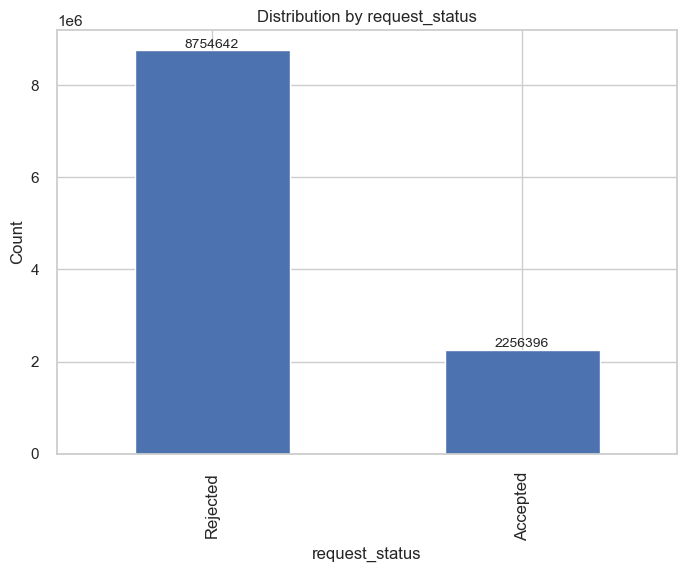

In [36]:
ax = fulldata["request_status"].value_counts().plot(kind="bar")
plt.title("Distribution by request_status", fontsize=12)
plt.xlabel("request_status", fontsize=12)
plt.xticks((0, 1), ('Rejected', 'Accepted'), fontsize = 12)
plt.ylabel("Count", fontsize=12)

# Add value labels on top of each bar
for i, count in enumerate(fulldata["request_status"].value_counts()):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()

### Examining relationships between variables: correlations and statistical inference

To check if there are statistically significant differences in groups of persons whose applications were received and those whose applications for loans were rejected with regard to numerical variables, t-tests of statistical signifficance as well as confidence intervals of differences between groups of persons were calculated.

#### Statistical significance test (t-test):

In [37]:
conf_levels = [0.9, 0.95, 0.99]
summary_list = []
results_list = []
for conf_level in conf_levels:
    significant = []
    unsignificant = [] 
    accepted_list = []
    rejected_list = []
    for feature in fulldata.iloc[:,:4].columns.values:
        summary, results = rp.ttest(group1= fulldata[feature][fulldata['request_status'] == 0], group1_name= "Rejected",
             group2= fulldata[feature][fulldata['request_status'] == 1], group2_name= "Accepted")
        summary["feature"] = feature
        summary[conf_level] = conf_level
        results["feature"] = feature
        results["conf_level"] = conf_level
        summary_list.append(summary)
        results_list.append(results)
        print(f'Confidence level - {conf_level}:')
        print(summary)
        print(results)
        print("")
        if results.iloc[3,1] < (1 - conf_level):
            print(f'There is the statistically significant difference \n\
    between means of {feature} in groups of {summary.iloc[1,0]} and {summary.iloc[0,0]}.')
            significant.append(feature)
            if results.iloc[0,1] < 0:
                print(f'The mean of the feature {feature} is higher in the group Accepted.')
                accepted_list.append(feature)
                print('')
            else:
                print(f'The mean of the feature {feature} is higher in the group Rejected.')
                rejected_list.append(feature)
                print('')
        else:
            print(f'There is no statistically significant difference \n\
    between means of {feature} in groups of {summary.iloc[1,0]} and {summary.iloc[0,0]}.')
            unsignificant.append(feature)
            print('')
    print(f'For the confidence level {conf_level} significant statistical differences in groups of {summary.iloc[1,0]} and {summary.iloc[0,0]} \n\
    are between means for these variables:\n\
    {significant})')
    print('')
    print(f'For the confidence level {conf_level} unsignificant statistical differences in groups of {summary.iloc[1,0]} and {summary.iloc[0,0]} \n\
    are between means for these variables:\n\
    {unsignificant})')
    print('')
    print(f'Higher means in the group Accepted: {accepted_list}')
    print('')
    print(f'Higher means in the group Rejected: {rejected_list}')
    print('')

Confidence level - 0.9:
   Variable           N          Mean            SD        SE     95% Conf.  \
0  Rejected   8754642.0  12631.124286  10840.320055  3.663725  12623.943516   
1  Accepted   2256396.0  15037.668111   9183.985132  6.113973  15025.684938   
2  combined  11011038.0  13124.276327  10566.906297  3.184445  13118.034929   

       Interval      feature  0.9  
0  12638.305057  loan_amount  0.9  
1  15049.651284  loan_amount  0.9  
2  13130.517725  loan_amount  0.9  
                    Independent t-test       results      feature  conf_level
0  Difference (Rejected - Accepted) =  -2.406544e+03  loan_amount         0.9
1                Degrees of freedom =   1.101104e+07  loan_amount         0.9
2                                 t =  -3.063384e+02  loan_amount         0.9
3             Two side test p value =   0.000000e+00  loan_amount         0.9
4            Difference < 0 p value =   0.000000e+00  loan_amount         0.9
5            Difference > 0 p value =   1.00000

Confidence level - 0.95:
   Variable           N       Mean         SD        SE  95% Conf.   Interval  \
0  Rejected   8754642.0  24.294513  20.861543  0.007051  24.280694  24.308332   
1  Accepted   2256396.0  18.570013   9.297178  0.006189  18.557882  18.582144   
2  combined  11011038.0  23.121441  19.211284  0.005790  23.110094  23.132789   

  feature  0.95  
0     dti  0.95  
1     dti  0.95  
2     dti  0.95  
                    Independent t-test       results feature  conf_level
0  Difference (Rejected - Accepted) =   5.724500e+00     dti        0.95
1                Degrees of freedom =   1.101104e+07     dti        0.95
2                                 t =   4.020298e+02     dti        0.95
3             Two side test p value =   0.000000e+00     dti        0.95
4            Difference < 0 p value =   1.000000e+00     dti        0.95
5            Difference > 0 p value =   0.000000e+00     dti        0.95
6                         Cohen's d =   3.002000e-01     dti       

In [38]:
summary_df = pd.concat([df for idx, df in enumerate(summary_list)], axis = 0)
summary_df.to_csv("summary_df.csv")
results_df = pd.concat([df for idx, df in enumerate(results_list)], axis = 0)
results_df.to_csv("results_df.csv")

##### Confidence intervals for mean differences between groups:

The same result as in the calculation of t-tests was observed when confidence intervals for mean differences between groups of customers who bought the travel insurance package and who didn't were calculated. it was found that differences between groups of customers with regards of all three numerical variables are statistically significant.

In [39]:
conf_levels = [0.9,0.95,0.99]
for conf_level in conf_levels:
    significant = []
    unsignificant = []
    for feature in fulldata.iloc[:,:4].columns.values:
        summary, results = rp.ttest(group1= fulldata[feature][fulldata['request_status'] == 0], group1_name= "Rejected",
                 group2= fulldata[feature][fulldata['request_status']== 1], group2_name= "Accepted")
        lower = ((summary.iloc[0,2] - summary.iloc[1,2])
        - stats.t.ppf((1+conf_level)/2., summary.iloc[2,1]-1)
        * (math.sqrt((summary.iloc[0,4])**2/summary.iloc[0,1] + (summary.iloc[1,4])**2/summary.iloc[1,1])))

        upper = ((summary.iloc[0,2] - summary.iloc[1,2])
        + stats.t.ppf((1+conf_level)/2., summary.iloc[2,1]-1)
        * (math.sqrt((summary.iloc[0,4])**2/summary.iloc[0,1] + (summary.iloc[1,4])**2/summary.iloc[1,1])))
        print(f'Confidence level - {conf_level}:')
        print(f'There is a {conf_level*100} chance that the confidence interval of {lower.round(3), upper.round(3)} \
    contains the true difference \nbetween means of {feature} in groups of {summary.iloc[1,0]} and {summary.iloc[0,0]}.')
        print('')
        if (lower < 0 and upper < 0) or (lower > 0 and upper > 0):
            print(f'Since this interval does not contain the value “0” it means \n\
    that it’s highly likely that there is a true difference between \n\
    means of {feature} in groups of {summary.iloc[1,0]} and {summary.iloc[0,0]}.')
            print('')
            significant.append(feature)
        else:
            print(f'Since this interval contains the value “0” it means that it’s unlikely \n\
    that there is a true difference between \n\
    means of {feature} in groups of {summary.iloc[1,0]} and {summary.iloc[0,0]}.')
            print('')
            unsignificant.append(feature)
    print('')
    print('')
    print(f'For confidence level {conf_level} significant statistical differences in groups of {summary.iloc[1,0]} and {summary.iloc[0,0]} \n\
    are between means for these variables:\n\
    {significant})')
    print('')
    print(f'For confidence level {conf_level} unsignificant statistical differences in groups of {summary.iloc[1,0]} and {summary.iloc[0,0]} \n\
    are between means for these variables:\n\
    {unsignificant})')
    print('')
    print('')

Confidence level - 0.9:
There is a 90.0 chance that the confidence interval of (-2406.551, -2406.537)     contains the true difference 
between means of loan_amount in groups of Accepted and Rejected.

Since this interval does not contain the value “0” it means 
    that it’s highly likely that there is a true difference between 
    means of loan_amount in groups of Accepted and Rejected.

Confidence level - 0.9:
There is a 90.0 chance that the confidence interval of (-5.489, -5.489)     contains the true difference 
between means of emp_length in groups of Accepted and Rejected.

Since this interval does not contain the value “0” it means 
    that it’s highly likely that there is a true difference between 
    means of emp_length in groups of Accepted and Rejected.

Confidence level - 0.9:
There is a 90.0 chance that the confidence interval of (5.724, 5.725)     contains the true difference 
between means of dti in groups of Accepted and Rejected.

Since this interval does not conta

It was found that for all significance levels:
 - there are significantly higher means of variables 'loan_amount', 'emp_length' and 'risk_score' in the group 'accepted';
 - there are significantly higher means of variables 'dti' in the group 'rejected'.

#### Correlations between numerical variables:


Next, it was examined if there are correlations between numerical variables. It was found that numerical variables of the full dataset are not correlated between each other.

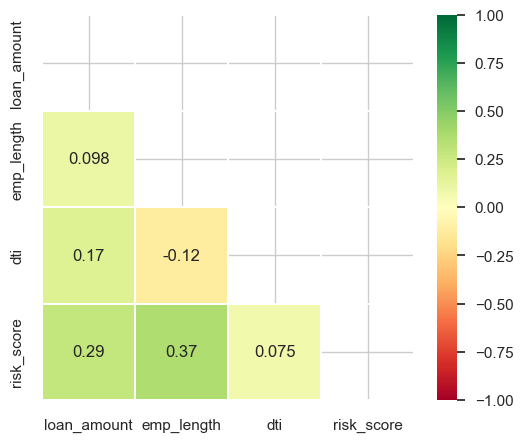

In [40]:
correlation_matrix = fulldata.iloc[:, :-1].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', 
            vmin=-1, vmax=1, linewidths=0.2, mask=mask)

fig = plt.gcf()
fig.set_size_inches(6, 5)

plt.show();

### Machine learning

#### Randomly selecting the data for machine learning

In order to train the model which would predict if the requests for loans would be accepted or rejected, the data was randomly sampled.

In [41]:
fulldata_sample = fulldata.sample(n=40000)


#### Spliting the data into training, validation, and test datasets

First, the data were split into feature variables and a target variable as well as into training, validation testing datasets. 

In [42]:
X = fulldata_sample.drop(['request_status'],axis=1)
y = fulldata_sample['request_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=123)

#### Building a machine learning pipeline

Next, pipelines of transforming data were constructed. As data were numerical, the standart scaler was applied to transform the variables into comparable scales.

In [43]:
numeric_transformer = Pipeline(steps=[
      ('scaler', StandardScaler())
])


In [44]:
numeric_features = ['emp_length', 'risk_score','loan_amount','dti']


In [45]:
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
]) 

In [46]:
classifiers = [
    xg.XGBClassifier()
    ,RandomForestClassifier()
    ,ExtraTreesClassifier()
    ,GradientBoostingClassifier()
    ,LogisticRegression()
    ,SVC()
    ,KNeighborsClassifier()
    ,BaggingClassifier()
    ,AdaBoostClassifier()]


Parameters were set in the dictionary to be used by random search hyperparameter tuning.

In [47]:
params = [  
        {'classifier__n_estimators' : [100, 500, 500],
        'classifier__max_depth' : [3, 6, 9],
        'classifier__learning_rate' : [0.01, 0.1, 0.3],
        'classifier__subsample' : [0.6, 0.8, 1.0]
        },

        {'classifier__n_estimators' : [100, 300, 500],
        'classifier__max_depth' : [3, 6, 9],
        'classifier__max_features' : [0.5, 0.8, 1.0],
        'classifier__bootstrap' : [True, False]
        },

        {'classifier__n_estimators' : [100, 300, 500],
        'classifier__max_depth' : [3, 6, 9],
      'classifier__max_features' : [0.5, 0.8, 1.0],
        'classifier__bootstrap' : [True, False]
        },

        {'classifier__n_estimators' : [100, 300, 500],
        'classifier__learning_rate' : [0.01, 0.1, 0.3],
        'classifier__max_depth' : [3, 6, 9],
       'classifier__max_features' : [0.5, 0.8, 1.0]},

        {'classifier__C' : [0.1, 1.0, 10.0],
        'classifier__penalty' : ['l1', 'l2'],
        'classifier__solver' : ['liblinear', 'saga']},

        {'classifier__C' : [0.1, 1.0, 10.0],
        'classifier__kernel' : ['linear', 'rbf', 'sigmoid'],
        'classifier__gamma' : ['scale', 'auto']},

        {'classifier__n_neighbors' : [3, 5, 7],
        'classifier__weights' : ['uniform', 'distance'],
        'classifier__algorithm' : ['auto', 'ball_tree', 'kd_tree'],
        'classifier__leaf_size' : [30, 60, 90]},

        {'classifier__n_estimators' : [100, 300, 500],
        'classifier__max_features' : [0.5, 0.8, 1.0],
        'classifier__bootstrap' : [True, False]
        },

        {'classifier__n_estimators' : [100, 300, 500],
        'classifier__learning_rate' : [0.01, 0.1, 0.3]}]

#### Running the machine learning pipeline

The function for runing the model, hyperparameter tuning by the random search CV, cross-validating, calculating metrics and outputing the scores was created.

In [48]:
def score_randomsearch_model(x_train, y_train, x_val, y_val, estimator, df, models_list, classes, size, **kwargs):
    
    # Fitting model and prediction:
    pipeline = imbPipeline(steps = [
                   ('preprocessor', preprocessor),
                   ('smote', SMOTE()),
                   ('classifier',classifier)])
    
    rand_pipeline = RandomizedSearchCV(pipeline, params[classifiers.index(classifier)], n_iter=10, 
                                   scoring='accuracy', cv=5, refit=True)
    model = rand_pipeline.fit(x_train, y_train)
    prediction = model.predict(x_val)
    
    #Cross_validation:
    cross_val = cross_validate(pipeline, x_train, y_train, cv=5, scoring=("accuracy", "f1"))
    
    #Metrics:
    prec = precision_score(y_val, prediction, average='macro').round(3)
    rec = recall_score(y_val, prediction).round(3)
    acc_sq = sum(list(cross_val.values())[2])/len(list(cross_val.values())[2])
    f1 = sum(list(cross_val.values())[3])/len(list(cross_val.values())[3])
  
    #Prints:
    print (estimator.__class__.__name__)
    conf = confusion_matrix(
        model, x_train, y_train, x_val, y_val, classes=classes,
        cmap="YlGn", size=size, **kwargs)
    print (f'Cross-validation')
    print ("Accuracy scores: {}".format(list(cross_val.values())[2]))
    print (f"Accuracy score (average): {acc_sq}")
    print ("F1 scores: {}".format(list(cross_val.values())[3]))
    print (f"F1 score (average): {f1}")
    print (f'Best parameters of the model:{model.best_params_}')
    print('')
    
    #Appends:
    cross_vals.append(cross_val)
    models_list.append(model)
    predictions.append(prediction)
    df["model_name"].append(f'{estimator.__class__.__name__}')
    df["a_score"].append(acc_sq)
    df["f1_score"].append(f1)
    df["precision_score"].append(prec)
    df["recall_score"].append(rec)

The function was run on all classifiers presented in the list of classifiers (above).

In [49]:
classes_status=['Rejected', 'Accepted']
size_status = (200, 100)

XGBClassifier


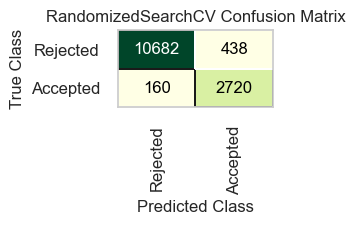

Cross-validation
Accuracy scores: [0.94357143 0.95321429 0.95035714 0.95142857 0.94607143]
Accuracy score (average): 0.9489285714285713
F1 scores: [0.8713355  0.88945148 0.8846473  0.88552189 0.87342833]
F1 score (average): 0.8808769004083974
Best parameters of the model:{'classifier__subsample': 1.0, 'classifier__n_estimators': 500, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.3}

RandomForestClassifier


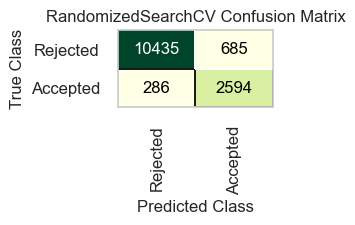

Cross-validation
Accuracy scores: [0.92642857 0.93107143 0.93035714 0.93392857 0.92785714]
Accuracy score (average): 0.9299285714285714
F1 scores: [0.83387097 0.83956775 0.84261501 0.84848485 0.83550489]
F1 score (average): 0.8400086923250456
Best parameters of the model:{'classifier__n_estimators': 100, 'classifier__max_features': 0.5, 'classifier__max_depth': 6, 'classifier__bootstrap': False}

ExtraTreesClassifier


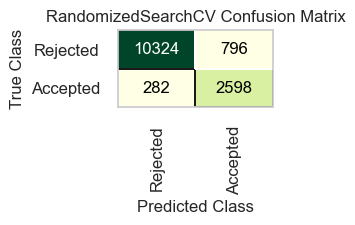

Cross-validation
Accuracy scores: [0.925      0.92571429 0.93       0.92964286 0.92607143]
Accuracy score (average): 0.9272857142857143
F1 scores: [0.82758621 0.82695507 0.84013051 0.83624273 0.82764363]
F1 score (average): 0.8317116288613005
Best parameters of the model:{'classifier__n_estimators': 100, 'classifier__max_features': 0.8, 'classifier__max_depth': 9, 'classifier__bootstrap': False}

GradientBoostingClassifier


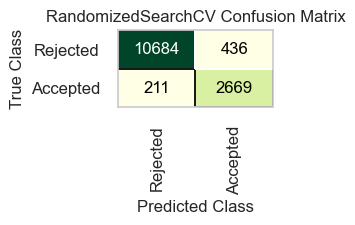

Cross-validation
Accuracy scores: [0.93035714 0.93857143 0.93357143 0.93892857 0.92642857]
Accuracy score (average): 0.9335714285714285
F1 scores: [0.84486874 0.85901639 0.85167464 0.86017989 0.83624801]
F1 score (average): 0.8503975335840946
Best parameters of the model:{'classifier__n_estimators': 300, 'classifier__max_features': 0.8, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.3}

LogisticRegression


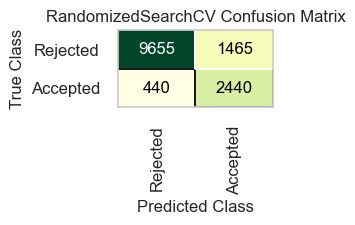

Cross-validation
Accuracy scores: [0.86428571 0.87357143 0.86535714 0.87       0.86607143]
Accuracy score (average): 0.8678571428571429
F1 scores: [0.71684054 0.73141123 0.72259014 0.72876304 0.72487161]
F1 score (average): 0.724895310488934
Best parameters of the model:{'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__C': 10.0}

SVC


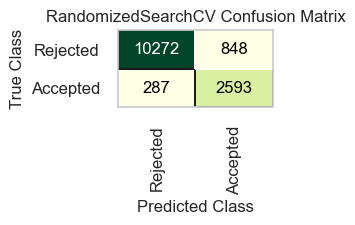

Cross-validation
Accuracy scores: [0.91571429 0.92178571 0.92321429 0.91892857 0.91714286]
Accuracy score (average): 0.9193571428571428
F1 scores: [0.81417323 0.82632831 0.83110762 0.81854516 0.81616482]
F1 score (average): 0.8212638281250234
Best parameters of the model:{'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__C': 1.0}

KNeighborsClassifier


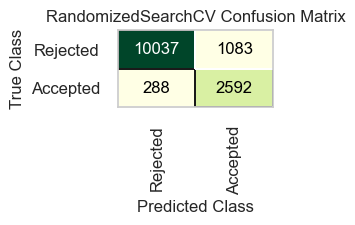

Cross-validation
Accuracy scores: [0.90392857 0.9075     0.90821429 0.90821429 0.8975    ]
Accuracy score (average): 0.9050714285714285
F1 scores: [0.79386973 0.8        0.80426504 0.79937549 0.78007663]
F1 score (average): 0.7955173779884278
Best parameters of the model:{'classifier__weights': 'distance', 'classifier__n_neighbors': 7, 'classifier__leaf_size': 60, 'classifier__algorithm': 'kd_tree'}

BaggingClassifier


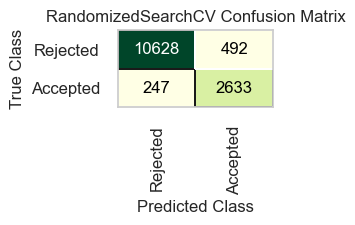

Cross-validation
Accuracy scores: [0.92428571 0.92214286 0.93035714 0.92821429 0.92035714]
Accuracy score (average): 0.9250714285714287
F1 scores: [0.82479339 0.81649832 0.83682008 0.8337469  0.81338912]
F1 score (average): 0.8250495616424033
Best parameters of the model:{'classifier__n_estimators': 100, 'classifier__max_features': 0.5, 'classifier__bootstrap': True}

AdaBoostClassifier


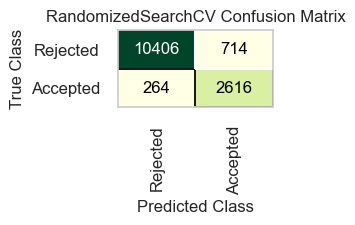

Cross-validation
Accuracy scores: [0.92642857 0.9375     0.9325     0.94178571 0.925     ]
Accuracy score (average): 0.9326428571428572
F1 scores: [0.83413849 0.85620378 0.84892086 0.86291001 0.82982172]
F1 score (average): 0.8463989711617632
Best parameters of the model:{'classifier__n_estimators': 300, 'classifier__learning_rate': 0.1}



In [50]:
cross_vals = []
models = []
predictions = []
scores = {}
scores["precision_score"] = []
scores["recall_score"] = []
scores["model_name"] = []
scores["a_score"] = []
scores["f1_score"] = []
for classifier in classifiers:
    score_randomsearch_model(X_train, y_train, X_val, y_val, classifier, scores, models, classes_status, size_status)

In [51]:
scores = pd.DataFrame(scores)
scores = scores.set_index('model_name')
scores

,precision_score,recall_score,a_score,f1_score
model_name,,,,
XGBClassifier,0.923,0.944,0.948929,0.880877
RandomForestClassifier,0.882,0.901,0.929929,0.840009
ExtraTreesClassifier,0.869,0.902,0.927286,0.831712
GradientBoostingClassifier,0.920,0.927,0.933571,0.850398
LogisticRegression,0.791,0.847,0.867857,0.724895
SVC,0.863,0.900,0.919357,0.821264
KNeighborsClassifier,0.839,0.900,0.905071,0.795517
BaggingClassifier,0.910,0.914,0.925071,0.825050
AdaBoostClassifier,0.880,0.908,0.932643,0.846399


In [52]:
for model in models:
    joblib.dump(model, f'model_request_status{models.index(model)}.joblib')

In [53]:
#scores = pd.DataFrame(scores).set_index("model_name")
scores.to_csv('scores_lending.csv')

In [54]:
scores = pd.DataFrame(scores).sort_values("a_score", ascending = False)

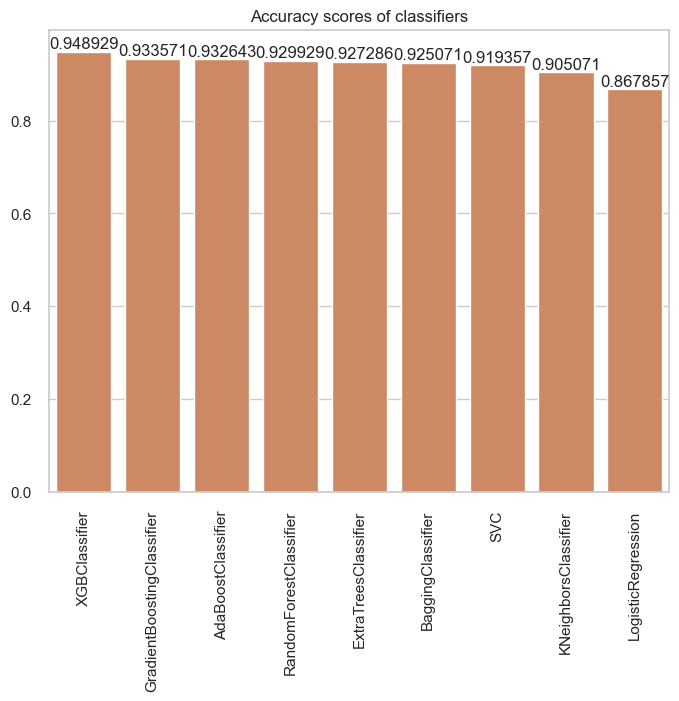

In [55]:
plot_bars(scores, "a_score", "", "Accuracy scores of classifiers")

It can be seen that the XgBoost classifier with the parameters ('classifier__subsample': 1.0, 'classifier__n_estimators': 500, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.3) generated the highest accuracy score.

#### Feature importances

Feature importances were calculated for ensemble classifiers.

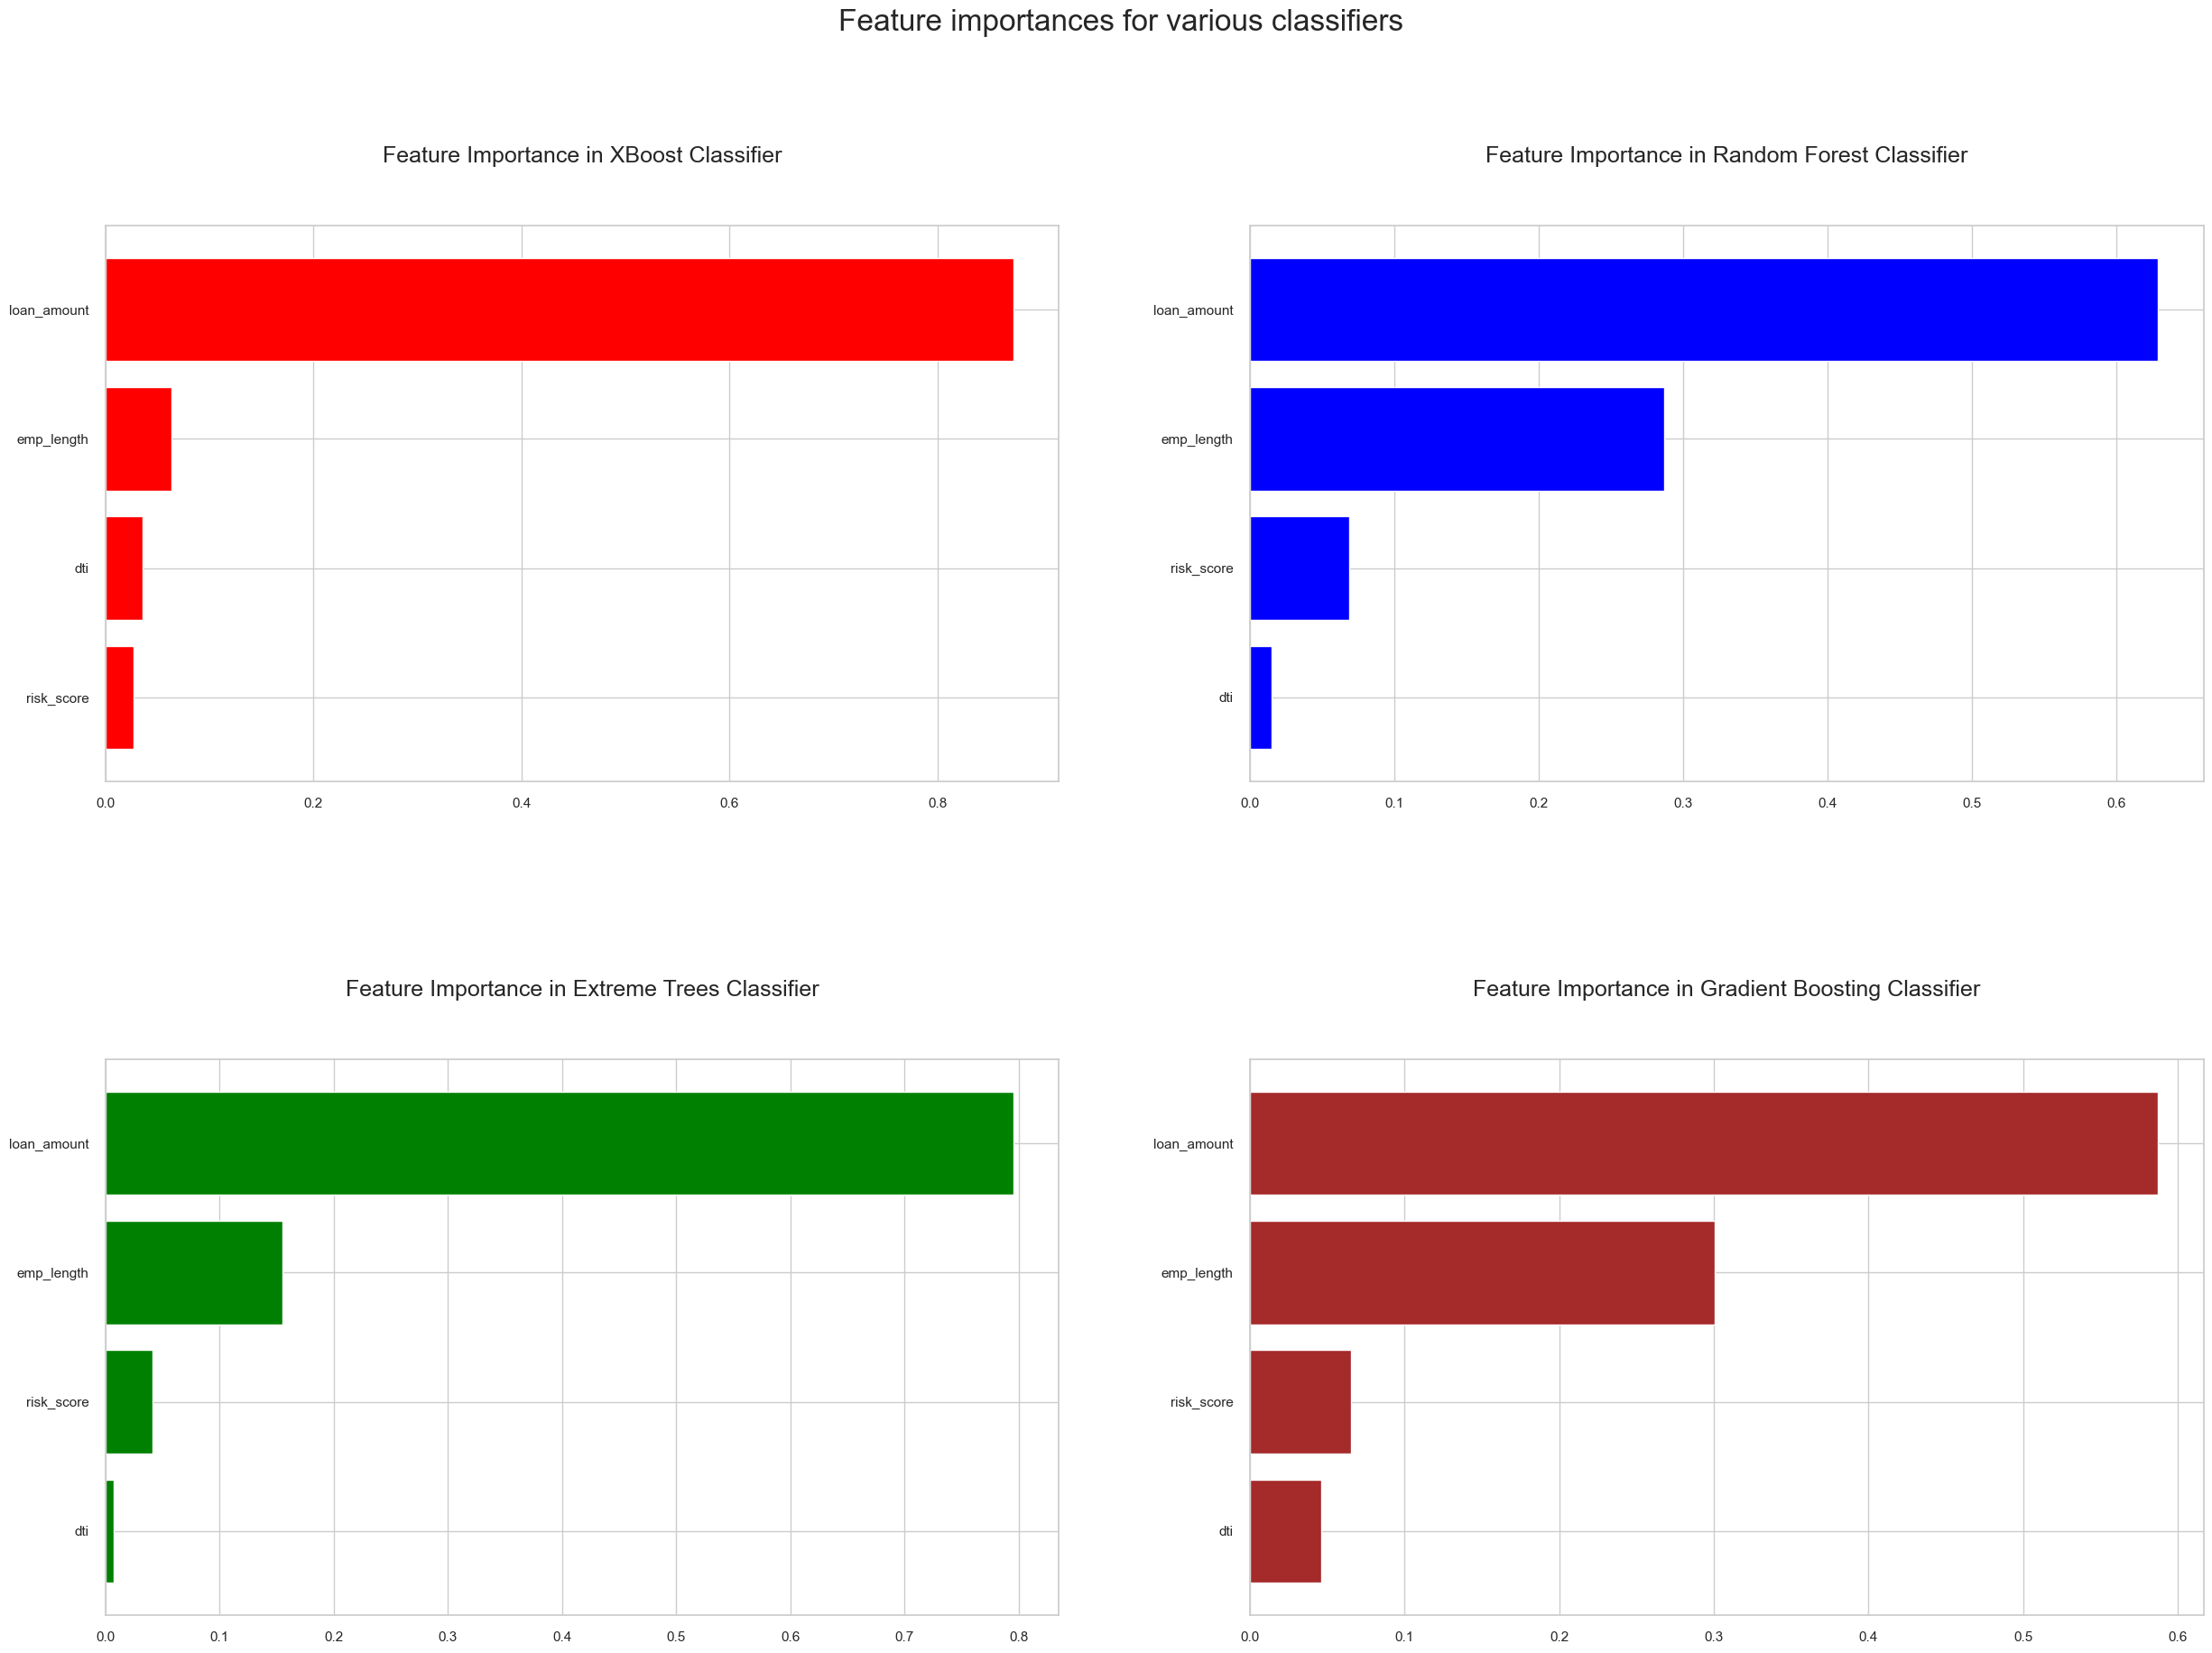

In [57]:
indices = [0, 1, 2, 3]
models_new = [models[index] for index in indices]
model_list = ['XBoost Classifier', 'Random Forest Classifier','Extreme Trees Classifier',
              'Gradient Boosting Classifier']
color_list = ['red','blue','green','brown']
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Feature importances for various classifiers", fontsize=24, y=1)

for model, ax in zip(models_new, axs.ravel()):
    pd.Series(model.best_estimator_[2].feature_importances_, index = X_test.columns).\
    sort_values(ascending=True).plot.barh(width=0.8,ax = ax,color=color_list[models_new.index(model)])
    ax.set_title(f'Feature Importance in {model_list[models_new.index(model)]}', fontsize=18, y=1.1)
    ax.set_xlabel("")

plt.show()

It can be observed that "loan_amount" and 'emp_length' are the most important features. 'dti is the least important.

#### Shap values for features

Another approach to feature selection is by using shap values which indicate feature importances as it is provided by the shap library.

In [262]:
shap_values_list = []
explainer_list = []
models_new = [models[index] for index in indices]
model_list = ['XgBoost Classifier','Random Forest Classifier','Extreme Trees Classifier',
              'Gradient Boosting Classifier']

for i in range(4):
    explainer = shap.TreeExplainer(models_new[i].best_estimator_[1])
    shap_values = explainer.shap_values(X_val)
    shap_values_list.append(shap_values)
    explainer_list.append(explainer)



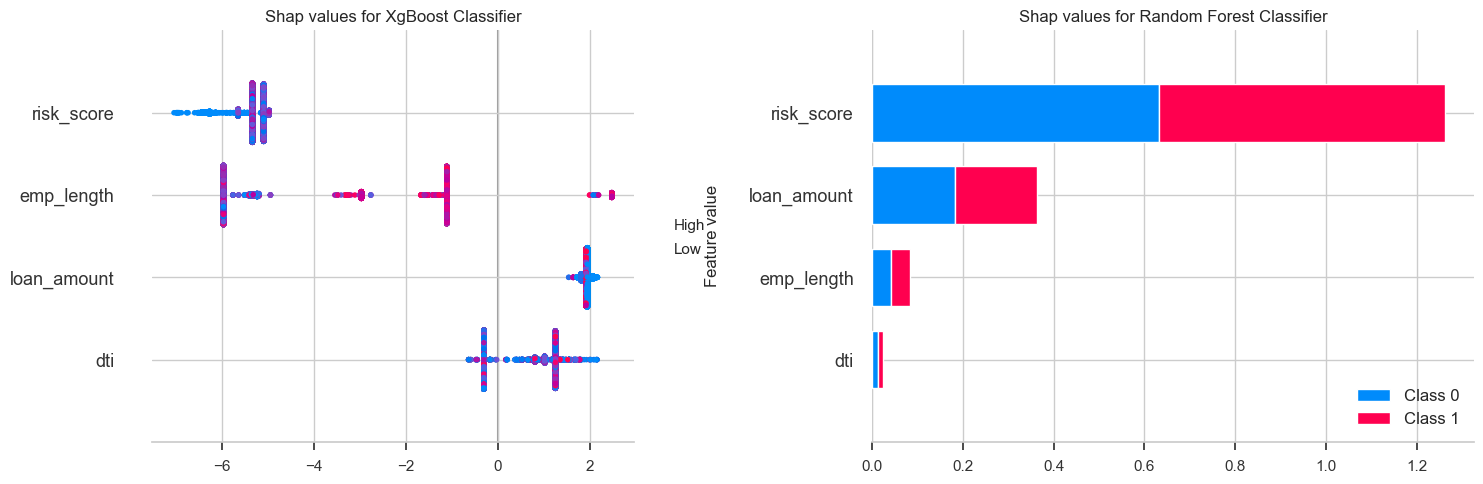

In [218]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
shap.summary_plot(shap_values_list[0], features = X_pipe_val, 
                     feature_names=X_val.columns, plot_size=None, show=False)
plt.title(f"Shap values for {model_list[0]}", fontsize = 12)
plt.xlabel('')
plt.ylabel('')
plt.subplot(1,2,2)
shap.summary_plot(shap_values_list[1], features = X_pipe_val, 
                     feature_names=X_val.columns, plot_size=None, show=False)
plt.title(f"Shap values for {model_list[1]}", fontsize = 12)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

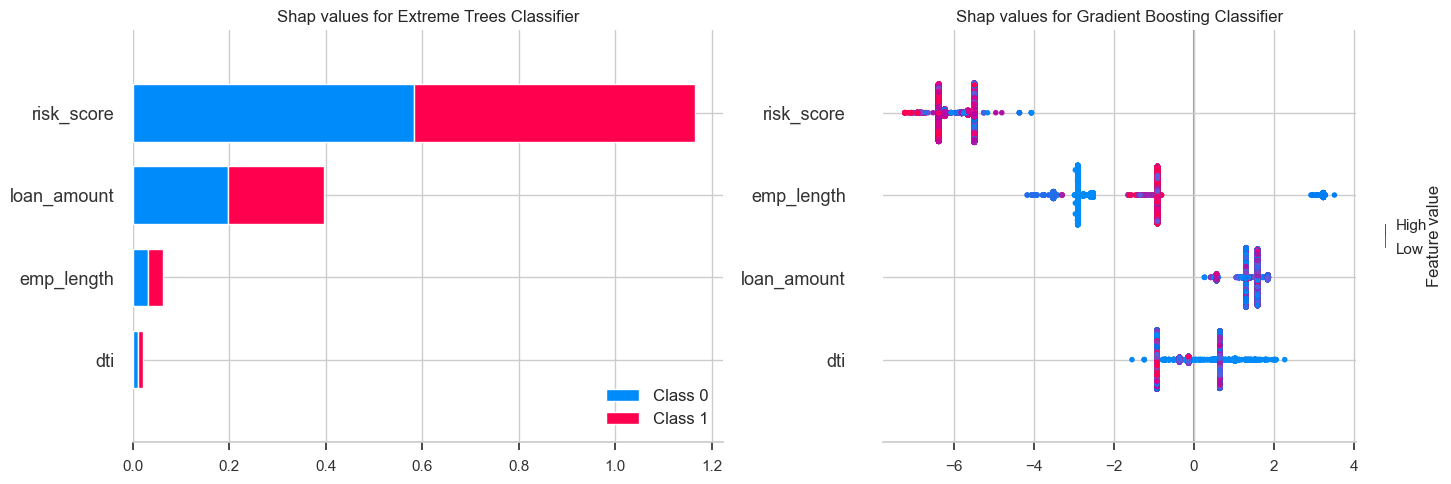

In [220]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
shap.summary_plot(shap_values_list[2], features = X_val, 
                     feature_names=X_val.columns, plot_size=None, show=False)
plt.title(f"Shap values for {model_list[2]}", fontsize = 12)
plt.xlabel('')
plt.ylabel('')
plt.subplot(1,2,2)
shap.summary_plot(shap_values_list[3], features = X_val, 
                     feature_names=X_val.columns, plot_size=None, show=False)
plt.title(f"Shap values for {model_list[3]}", fontsize = 12)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

It can be observed that for all ensemble classifiers 'rik_score' and 'loan_amount' have the highest shap values.

#### Feature selection based on feature importances

As the variable 'dti' had the lowest importance, it was decided to run the classifiers by dropping this feature. For that purpose, the function to select features from the dataset was created.

In [64]:
def feature_selector_for_preprocessor(num_feature_list, cat_feature_list):
    numeric_features_selected = num_feature_list
    categorical_features_selected = cat_feature_list
    preprocessor = ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_features_selected),
       # ('categorical', categorical_transformer, categorical_features_selected),
    ])
    return preprocessor

In [67]:
num_feature_list = ['emp_length', 'risk_score','loan_amount', 'dti']
cat_feature_list = []


In [70]:
preprocessor = feature_selector_for_preprocessor(num_feature_list, cat_feature_list)

The pipeline was run with the new combination of features for all classifiers. 

XGBClassifier


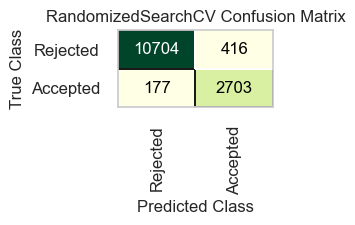

Cross-validation
Accuracy scores: [0.94321429 0.95428571 0.95571429 0.95178571 0.94821429]
Accuracy score (average): 0.9506428571428571
F1 scores: [0.87083672 0.89152542 0.89632107 0.88702929 0.87886383]
F1 score (average): 0.8849152654026913
Best parameters of the model:{'classifier__subsample': 1.0, 'classifier__n_estimators': 500, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.3}

RandomForestClassifier


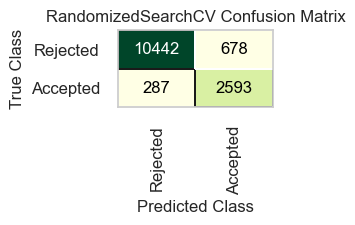

Cross-validation
Accuracy scores: [0.92678571 0.93428571 0.93071429 0.93392857 0.92642857]
Accuracy score (average): 0.9304285714285714
F1 scores: [0.83534137 0.84666667 0.84354839 0.84773663 0.8319739 ]
F1 score (average): 0.8410533887195533
Best parameters of the model:{'classifier__n_estimators': 500, 'classifier__max_features': 0.8, 'classifier__max_depth': 6, 'classifier__bootstrap': True}

ExtraTreesClassifier


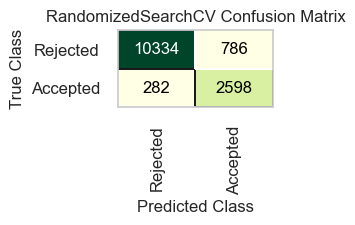

Cross-validation
Accuracy scores: [0.92428571 0.92428571 0.93       0.92892857 0.92714286]
Accuracy score (average): 0.9269285714285715
F1 scores: [0.82537068 0.82421227 0.84013051 0.83485477 0.83084577]
F1 score (average): 0.8310827992129299
Best parameters of the model:{'classifier__n_estimators': 300, 'classifier__max_features': 0.8, 'classifier__max_depth': 9, 'classifier__bootstrap': False}

GradientBoostingClassifier


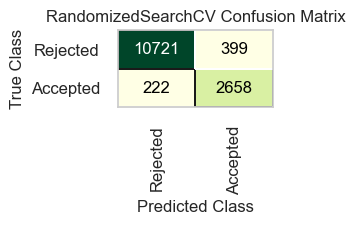

Cross-validation
Accuracy scores: [0.92892857 0.93785714 0.93535714 0.93964286 0.92642857]
Accuracy score (average): 0.9336428571428572
F1 scores: [0.84193805 0.85737705 0.85531575 0.86136177 0.83546326]
F1 score (average): 0.8502911746761747
Best parameters of the model:{'classifier__n_estimators': 500, 'classifier__max_features': 0.8, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.3}

LogisticRegression


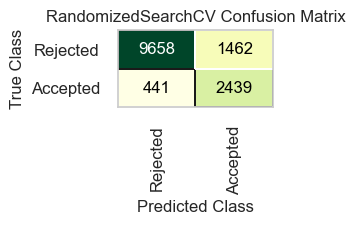

Cross-validation
Accuracy scores: [0.86464286 0.87392857 0.86392857 0.87       0.86678571]
Accuracy score (average): 0.8678571428571429
F1 scores: [0.718634   0.73196659 0.7192336  0.72795217 0.72593681]
F1 score (average): 0.7247446348681654
Best parameters of the model:{'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__C': 10.0}

SVC


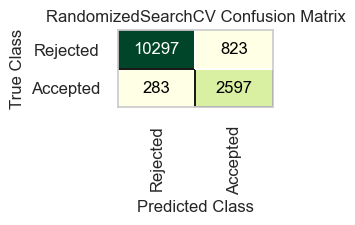

Cross-validation
Accuracy scores: [0.91607143 0.92357143 0.9225     0.92178571 0.91178571]
Accuracy score (average): 0.9191428571428573
F1 scores: [0.81452249 0.82907348 0.83060109 0.82295877 0.80688038]
F1 score (average): 0.8208072431837377
Best parameters of the model:{'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__C': 10.0}

KNeighborsClassifier


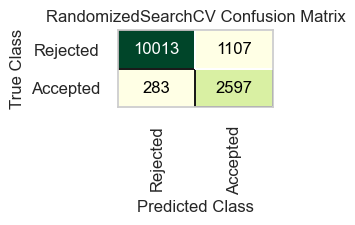

Cross-validation
Accuracy scores: [0.89857143 0.9075     0.90357143 0.9125     0.89785714]
Accuracy score (average): 0.9040000000000001
F1 scores: [0.78353659 0.80061586 0.79576399 0.80814409 0.77966102]
F1 score (average): 0.7935443084643417
Best parameters of the model:{'classifier__weights': 'distance', 'classifier__n_neighbors': 7, 'classifier__leaf_size': 60, 'classifier__algorithm': 'ball_tree'}

BaggingClassifier


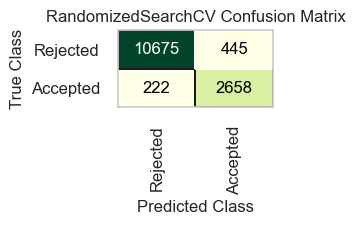

Cross-validation
Accuracy scores: [0.92464286 0.92142857 0.93142857 0.93       0.92107143]
Accuracy score (average): 0.9257142857142856
F1 scores: [0.8277551  0.81324278 0.84210526 0.83666667 0.8172043 ]
F1 score (average): 0.8273948234641905
Best parameters of the model:{'classifier__n_estimators': 300, 'classifier__max_features': 0.5, 'classifier__bootstrap': True}

AdaBoostClassifier


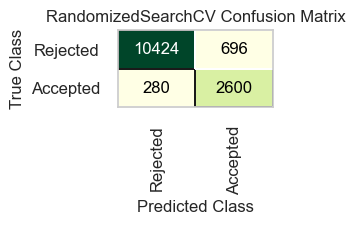

Cross-validation
Accuracy scores: [0.925      0.93535714 0.93535714 0.93821429 0.92857143]
Accuracy score (average): 0.9325000000000001
F1 scores: [0.83173077 0.84979253 0.85508407 0.85643154 0.83792545]
F1 score (average): 0.8461928697159277
Best parameters of the model:{'classifier__n_estimators': 300, 'classifier__learning_rate': 0.1}



In [72]:
cross_vals = []
models_selected = []
predictions = []
scores_selected = {}
scores_selected["precision_score"] = []
scores_selected["recall_score"] = []
scores_selected["model_name"] = []
scores_selected["a_score"] = []
scores_selected["f1_score"] = []
for classifier in classifiers:
    score_randomsearch_model(X_train, y_train, X_val, y_val, classifier, scores_selected, 
                models_selected, classes_status, size_status)

In [73]:
scores_selected = pd.DataFrame(scores_selected)
scores_selected = scores_selected.set_index('model_name')
scores_selected

,precision_score,recall_score,a_score,f1_score
model_name,,,,
XGBClassifier,0.925,0.939,0.950643,0.884915
RandomForestClassifier,0.883,0.900,0.930429,0.841053
ExtraTreesClassifier,0.871,0.902,0.926929,0.831083
GradientBoostingClassifier,0.925,0.923,0.933643,0.850291
LogisticRegression,0.791,0.847,0.867857,0.724745
SVC,0.866,0.902,0.919143,0.820807
KNeighborsClassifier,0.837,0.902,0.904000,0.793544
BaggingClassifier,0.918,0.923,0.925714,0.827395
AdaBoostClassifier,0.881,0.903,0.932500,0.846193


In [74]:
for model in models_selected:
    joblib.dump(model, f'model_selected_request_status{models_selected.index(model)}.joblib')

In [75]:
#scores = pd.DataFrame(scores).set_index("model_name")
scores_selected.to_csv('scores_lending_selected.csv')

In [76]:
scores_selected = pd.DataFrame(scores_selected).sort_values("a_score", ascending = False)

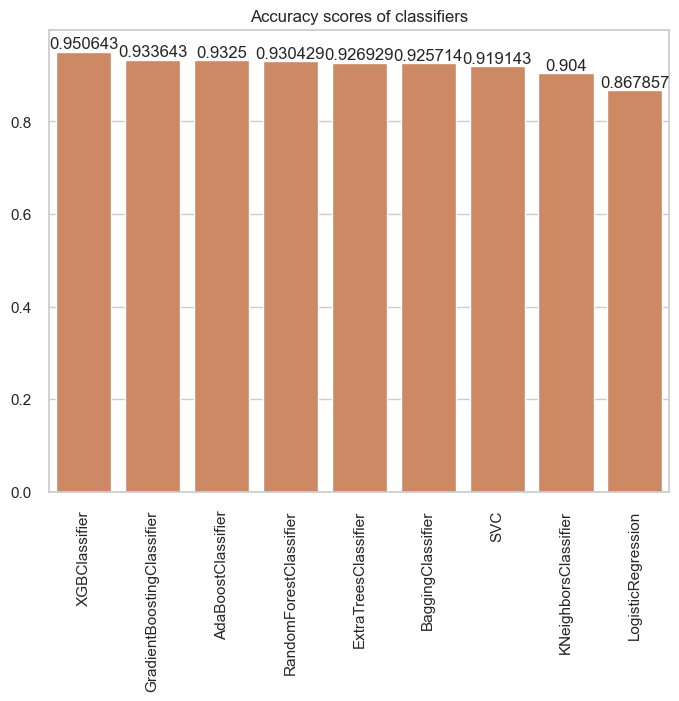

In [77]:
plot_bars(scores_selected, "a_score", "", "Accuracy scores of classifiers")

It was found that the Gradient Boost classifier generated the highest accuracy score, however, the score was a bit lower comparing with the score of the best classifier with the full list of variables. 

#### Hyperparameter tuning - Bayesian optimization

Also for the selected list of features, the hyperparameter tuning with the Bayesian optimization (Optuna library) was performed.

As the Optuna function was not included into the pipeline, it was needed to preprocess and resample data separatly and then run the function with the certain parameters and different classifiers. 

In [105]:
X_pipe = pd.DataFrame(preprocessor.fit_transform(X))
X_pipe_train = pd.DataFrame(preprocessor.fit_transform(X_train))
X_pipe_val = pd.DataFrame(preprocessor.fit_transform(X_val))
X_pipe_test = pd.DataFrame(preprocessor.fit_transform(X_test))

smote = SMOTE()
X_resampled_train, y_resampled_train = smote.fit_resample(X_pipe_train, y_train)


In [178]:
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['XGB', 'RF', 'ET', 'GB', 'LR', 'SVC', 'KNN', 'Bagging', 'AdaBoost'])

    if classifier_name == 'XGB':
        classifier = xg.XGBClassifier(
        n_estimators = trial.suggest_int("n_estimators", 100,1000, step = 100),
        max_depth = trial.suggest_int('max_depth', 3, 9, step = 3),
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log = True),
        subsample = trial.suggest_float('subsample', 0.6, 1, step = 0.2)
        )
        classifier.fit(X_pipe_train, y_train)

    elif classifier_name == 'RF':
        classifier = RandomForestClassifier(
        max_features = trial.suggest_int("max_features", 6,32, step = 5),
        n_estimators = trial.suggest_int("n_estimators", 10,101, step = 10),
        max_depth = trial.suggest_int("rf_max_depth", 2, 64, log=True),
        max_samples = trial.suggest_float("max_samples",0.2, 1),
        random_state = 42
        )
        classifier.fit(X_pipe_train, y_train)
        
    elif classifier_name == 'ET':
        classifier = ExtraTreesClassifier(
        n_estimators = trial.suggest_int("n_estimators", 100,500, step = 200),
        max_features = trial.suggest_int("max_features", 6,32, step = 5),
        max_depth = trial.suggest_int('max_depth',1, 9, step = 4),
        )
        classifier.fit(X_pipe_train, y_train)
        
    elif classifier_name == 'GB':
        classifier = GradientBoostingClassifier(
        n_estimators = trial.suggest_int("n_estimators", 100,500, step = 200),
        max_depth = trial.suggest_int("rf_max_depth", 2, 64, log=True),
        max_features = trial.suggest_int("max_features", 6,32, step = 5),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log = True)
        )
        classifier.fit(X_pipe_train, y_train)
        
    elif classifier_name == 'LR':
        classifier = LogisticRegression(
            C=trial.suggest_float('C', 1, 9, step = 4),
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            solver=trial.suggest_categorical('solver', ['liblinear', 'saga'])
        )
        classifier.fit(X_pipe_train, y_train)
        
    elif classifier_name == 'SVC':
        classifier = SVC(
            C=trial.suggest_float('C', 1, 9, step = 4),
            kernel=trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid']),
            gamma=trial.suggest_categorical('gamma', ['scale', 'auto'])
        )
        classifier.fit(X_pipe_train, y_train)
        
    elif classifier_name == 'KNN':
        classifier = KNeighborsClassifier(
            n_neighbors=trial.suggest_int('n_neighbors', 3, 7, step = 2),
            weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
            leaf_size=trial.suggest_int('leaf_size', 30, 90, step = 30)
        )
        classifier.fit(X_pipe_train, y_train)
        
    elif classifier_name == 'Bagging':
        classifier = BaggingClassifier(
            n_estimators=trial.suggest_int('n_estimators', 10, 90, step = 20),
            max_features = trial.suggest_int("max_features", 6,32, step = 5),
            max_samples=trial.suggest_float('max_samples', 0.5, 0.9, step = 0.2),
        )
        classifier.fit(X_pipe_train, y_train)
        
    else:
        classifier = AdaBoostClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 200, step = 50),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 10.0, log = True)
        )
        classifier.fit(X_pipe_train, y_train)
    
    y_pred = classifier.predict(X_pipe_val)
    score = accuracy_score(y_val, y_pred)

    return score


In [179]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 100)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

Best Score:  0.923
Best Params: 
  classifier: SVC
  C: 9.0
  kernel: rbf
  gamma: auto


The Optuna study found that the best classifier is the Support Vector Machine with the parameters (C: 9.0,kernel: rbf, gamma: auto). However, the score of the suggested classifier is lower than the scores of classifiers tuned with the random search CV. 

#### Predicting values and evaluating tuned models on the test dataset

The models were tested on the test data. 

##### For a model tuned by the Bayesian optimization:

SVC


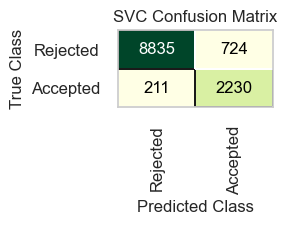

Accuracy score: 0.922
F1 score: 0.827
Precision: 0.755
Recall: 0.914


In [106]:
model_svc = SVC(C = 9, kernel = "rbf",gamma = "auto").fit(X_resampled_train, y_resampled_train)
prediction = model_svc.predict(X_pipe_test)

# Metrics:
prec = precision_score(y_test, prediction).round(3)
rec = recall_score(y_test, prediction).round(3)
acc_sq = accuracy_score(y_test, prediction).round(3)
f1 = f1_score(y_test, prediction).round(3)
#Prints:
print (model_svc.__class__.__name__)
conf = confusion_matrix(
    model_svc, X_resampled_train, y_resampled_train, X_pipe_test, y_test, classes=['Rejected','Accepted'],
    cmap="YlGn", size=(200,100))
print (f"Accuracy score: {acc_sq}")
print (f"F1 score: {f1}")
print (f"Precision: {prec}")
print (f"Recall: {rec}")

In [107]:
joblib.dump(model_svc, f'model_svc.joblib')

['model_svc.joblib']

##### For a models tuned by the random search:

XGBClassifier


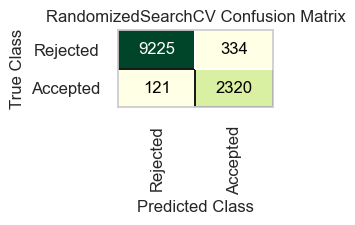

Accuracy score: 0.962
F1 score: 0.911

RandomForestClassifier


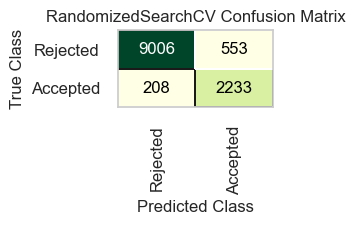

Accuracy score: 0.937
F1 score: 0.854

ExtraTreesClassifier


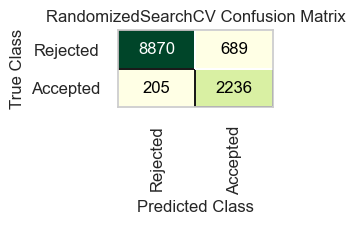

Accuracy score: 0.926
F1 score: 0.833

GradientBoostingClassifier


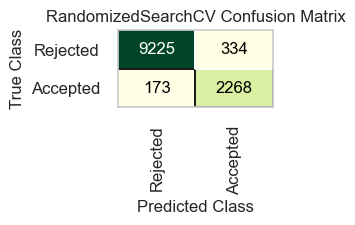

Accuracy score: 0.958
F1 score: 0.899

LogisticRegression


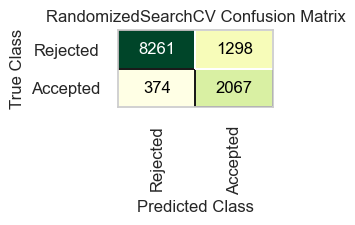

Accuracy score: 0.861
F1 score: 0.712

SVC


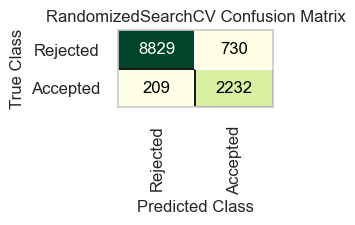

Accuracy score: 0.922
F1 score: 0.826

KNeighborsClassifier


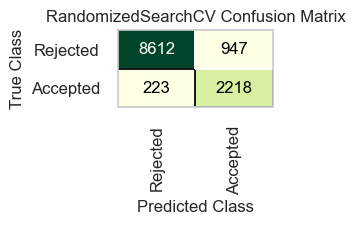

Accuracy score: 0.902
F1 score: 0.791

BaggingClassifier


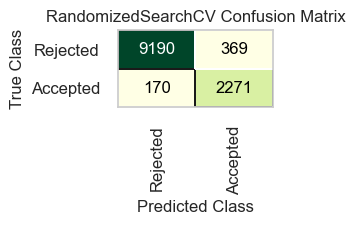

Accuracy score: 0.955
F1 score: 0.894

AdaBoostClassifier


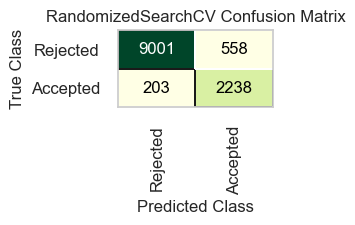

Accuracy score: 0.937
F1 score: 0.855



In [108]:
cross_vals = []
predictions = []
models_final = []
scores_final = {}
scores_final["precision_score"] = []
scores_final["recall_score"] = []
scores_final["model_name"] = []
scores_final["a_score"] = []
scores_final["f1_score"] = []
for model in models_selected:
    prediction = model.best_estimator_.predict(X_test)
     
    f1 = f1_score(y_test, prediction).round(3)
    prec = precision_score(y_test, prediction, average='macro').round(3)
    rec = recall_score(y_test, prediction).round(3)
    acc_sq = accuracy_score(y_test, prediction).round(3)
    
    print (model.best_estimator_[2].__class__.__name__)
    conf = confusion_matrix(model, X_test, y_test, classes=['Rejected', 'Accepted'],
        cmap="YlGn", size=(200, 100))
    print (f"Accuracy score: {acc_sq}")
    print (f"F1 score: {f1}")
    print('')
    
    predictions.append(prediction)
    models_final.append(model)
    scores_final["model_name"].append(f'{model.best_estimator_[2].__class__.__name__}')
    scores_final["a_score"].append(acc_sq)
    scores_final["f1_score"].append(f1)
    scores_final["precision_score"].append(prec)
    scores_final["recall_score"].append(rec)

In [109]:
for model in models_final:
    joblib.dump(model, f'model_selected_request_status_manual{models_final.index(model)}.joblib')

In [110]:
scores_final = pd.DataFrame(scores_final)
scores_final = scores_final.set_index('model_name')
scores_final

,precision_score,recall_score,a_score,f1_score
model_name,,,,
XGBClassifier,0.931,0.950,0.962,0.911
RandomForestClassifier,0.889,0.915,0.937,0.854
ExtraTreesClassifier,0.871,0.916,0.926,0.833
GradientBoostingClassifier,0.927,0.929,0.958,0.899
LogisticRegression,0.785,0.847,0.861,0.712
SVC,0.865,0.914,0.922,0.826
KNeighborsClassifier,0.838,0.909,0.902,0.791
BaggingClassifier,0.921,0.930,0.955,0.894
AdaBoostClassifier,0.889,0.917,0.937,0.855


In [111]:
scores_final = pd.DataFrame(scores_final).sort_values("a_score", ascending = False)

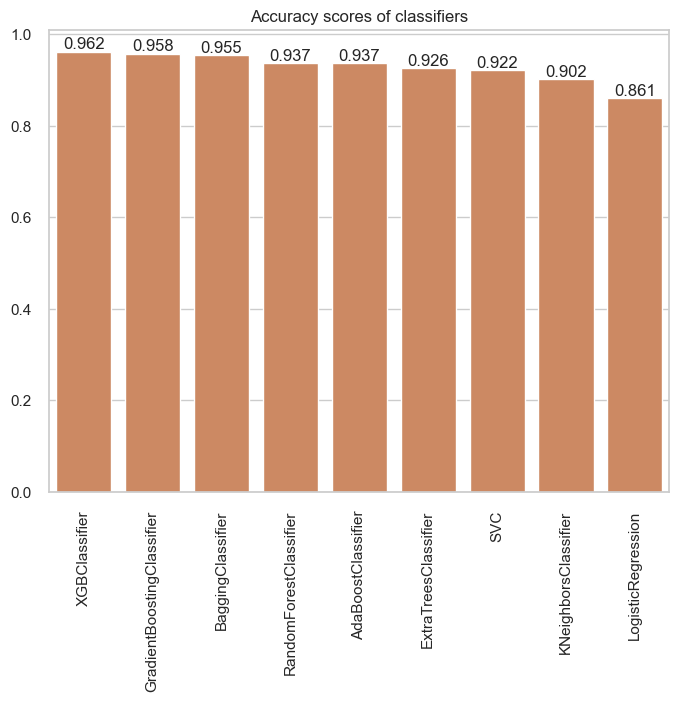

In [112]:
plot_bars(scores_final, "a_score", "", "Accuracy scores of classifiers")

In [113]:
joblib.dump(models_final[0], 'best_model_request_status_Xgboost.joblib')

['best_model_request_status_Xgboost.joblib']

It can be seen that scores calculated after predictions generated with the models are not significantly lower than scores of predictions generated on the validation data. The Bagging classifier performs the best on the test data. It can be concluded, that models neither underfit nor overfit.

#### Using the selected model for prediction

The machine learning model which was trained and tested on the data in the landing club datasets could be used for predicting probability that a person will receive a loan based on input values that he or she provides. Bellow the code is provided for getting input values, adding them as a row to the test dataset, preprocessing the data, predicting probability values on the pretrained model.

In [123]:
model = joblib.load('request_status_Xgboost.joblib')

In [129]:
inp1 = int(input("What is the loan amount the applicant requested?: "))
inp2 = int(input("How many years has the applicant been employed?: "))
inp3 = float(input("What is the debt-to-income ratio of the applicant?: "))
inp4 = float(input("What is the risk score of the applicant?: "))

What is the loan amount the applicant requested?: 1000
How many years has the applicant been employed?: 10
What is the debt-to-income ratio of the applicant?: 20
What is the risk score of the applicant?: 700


In [135]:
X_prediction = X_test.copy()

In [139]:
len(X_prediction)

12001

In [136]:
X_prediction.loc[len(X_prediction.index)] = [inp1, inp2, inp3, inp4] 

In [138]:
prob = []
pred = []
prob = model.predict_proba(X_prediction)
pred = model.predict(X_prediction)

print(f' Probability that the applicants request to get a loan will be accepted is {prob[12000][1].round(3)}.')

 Probability that the applicants request to get a loan will be accepted is 0.7760000228881836.


### Conclusions for the I and II parts

From these parts of the analysis it can be concluded:
   1. Decisions if a person receives a loan or his or her application is rejected can be predicted with such features as:
   
   - employment length (persons with the longer employment length will more likely receive a loan);
   
   - risk score (persons whose risk score is higher will more likely receive a loan);
   
   - loan amount (applications for higher amounts of loans will more likely will be approved); and
   
   - debt to income ration (persons with higher debt to income ratios will less likely receive a loan);
   
   2. the classifier which performs the best on the test data is the Bagging classifier (accuracy score is 0.968).
   